# Machine Learning Engineer Nanodegree
## Supervised Learning
## Project: Finding Donors for *CharityML*

Welcome to the second project of the Machine Learning Engineer Nanodegree! In this notebook, some template code has already been provided for you, and it will be your job to implement the additional functionality necessary to successfully complete this project. Sections that begin with **'Implementation'** in the header indicate that the following block of code will require additional functionality which you must provide. Instructions will be provided for each section and the specifics of the implementation are marked in the code block with a `'TODO'` statement. Please be sure to read the instructions carefully!

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question X'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.  

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

## Getting Started

In this project, you will employ several supervised algorithms of your choice to accurately model individuals' income using data collected from the 1994 U.S. Census. You will then choose the best candidate algorithm from preliminary results and further optimize this algorithm to best model the data. Your goal with this implementation is to construct a model that accurately predicts whether an individual makes more than $50,000. This sort of task can arise in a non-profit setting, where organizations survive on donations.  Understanding an individual's income can help a non-profit better understand how large of a donation to request, or whether or not they should reach out to begin with.  While it can be difficult to determine an individual's general income bracket directly from public sources, we can (as we will see) infer this value from other publically available features. 

The dataset for this project originates from the [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/Census+Income). The datset was donated by Ron Kohavi and Barry Becker, after being published in the article _"Scaling Up the Accuracy of Naive-Bayes Classifiers: A Decision-Tree Hybrid"_. You can find the article by Ron Kohavi [online](https://www.aaai.org/Papers/KDD/1996/KDD96-033.pdf). The data we investigate here consists of small changes to the original dataset, such as removing the `'fnlwgt'` feature and records with missing or ill-formatted entries.

----
## Exploring the Data
Run the code cell below to load necessary Python libraries and load the census data. Note that the last column from this dataset, `'income'`, will be our target label (whether an individual makes more than, or at most, $50,000 annually). All other columns are features about each individual in the census database.

In [1]:
# Import libraries necessary for this project
import numpy as np
import pandas as pd
from time import time
from IPython.display import display # Allows the use of display() for DataFrames

# Import supplementary visualization code visuals.py
import visuals as vs

# Pretty display for notebooks
%matplotlib inline

# Load the Census dataset
data = pd.read_csv("census.csv")

# Success - Display the first record
display(data.head(n=1))

,age,workclass,education_level,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,Bachelors,13.0,Never-married,Adm-clerical,Not-in-family,White,Male,2174.0,0.0,40.0,United-States,<=50K


### Implementation: Data Exploration
A cursory investigation of the dataset will determine how many individuals fit into either group, and will tell us about the percentage of these individuals making more than \$50,000. In the code cell below, you will need to compute the following:
- The total number of records, `'n_records'`
- The number of individuals making more than \$50,000 annually, `'n_greater_50k'`.
- The number of individuals making at most \$50,000 annually, `'n_at_most_50k'`.
- The percentage of individuals making more than \$50,000 annually, `'greater_percent'`.

**Hint:** You may need to look at the table above to understand how the `'income'` entries are formatted. 

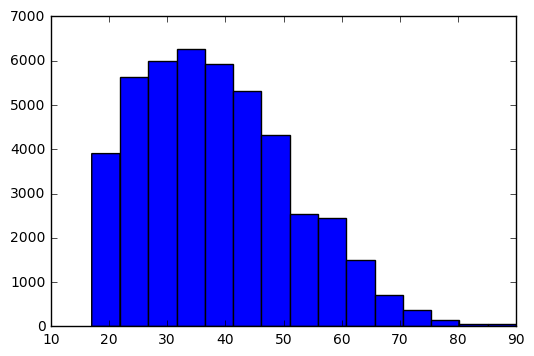

In [2]:
import matplotlib.pyplot as plt
plt.hist(data['age'], bins=15);


In [3]:
# TODO: Total number of records
n_records = len(data.index)

# TODO: Number of records where individual's income is more than $50,000
n_greater_50k = sum(data['income'] == '>50K')

# TODO: Number of records where individual's income is at most $50,000
n_at_most_50k = sum(data['income'] == '<=50K')

# TODO: Percentage of individuals whose income is more than $50,000
greater_percent = float(n_greater_50k) / n_records * 100

# Print the results
print "Total number of records: {}".format(n_records)
print "Individuals making more than $50,000: {}".format(n_greater_50k)
print "Individuals making at most $50,000: {}".format(n_at_most_50k)
print "Percentage of individuals making more than $50,000: {:.2f}%".format(greater_percent)

Total number of records: 45222
Individuals making more than $50,000: 11208
Individuals making at most $50,000: 34014
Percentage of individuals making more than $50,000: 24.78%


----
## Preparing the Data
Before data can be used as input for machine learning algorithms, it often must be cleaned, formatted, and restructured — this is typically known as **preprocessing**. Fortunately, for this dataset, there are no invalid or missing entries we must deal with, however, there are some qualities about certain features that must be adjusted. This preprocessing can help tremendously with the outcome and predictive power of nearly all learning algorithms.

### Transforming Skewed Continuous Features
A dataset may sometimes contain at least one feature whose values tend to lie near a single number, but will also have a non-trivial number of vastly larger or smaller values than that single number.  Algorithms can be sensitive to such distributions of values and can underperform if the range is not properly normalized. With the census dataset two features fit this description: '`capital-gain'` and `'capital-loss'`. 

Run the code cell below to plot a histogram of these two features. Note the range of the values present and how they are distributed.

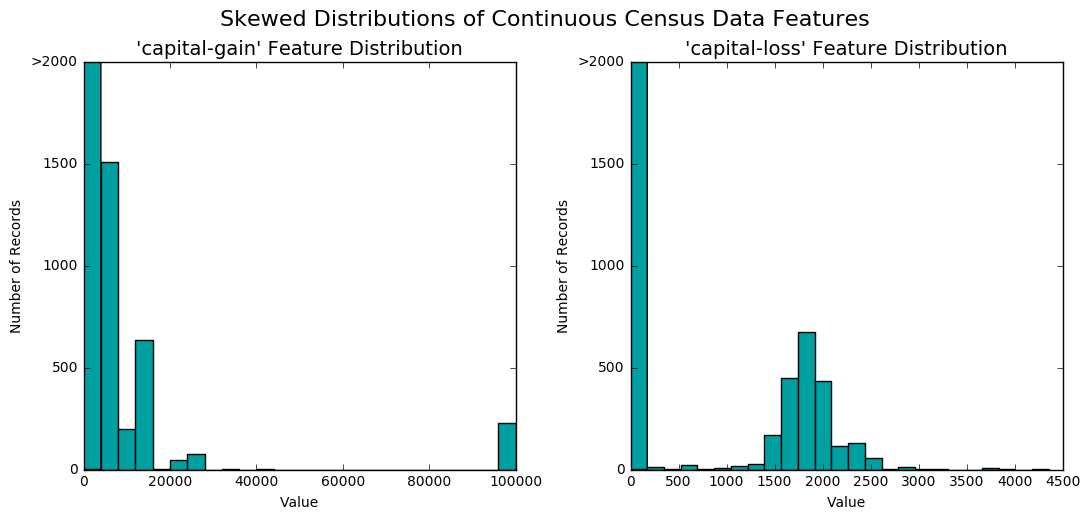

In [4]:
# Split the data into features and target label
income_raw = data['income']
features_raw = data.drop('income', axis = 1)

# Visualize skewed continuous features of original data
vs.distribution(data)

For highly-skewed feature distributions such as `'capital-gain'` and `'capital-loss'`, it is common practice to apply a <a href="https://en.wikipedia.org/wiki/Data_transformation_(statistics)">logarithmic transformation</a> on the data so that the very large and very small values do not negatively affect the performance of a learning algorithm. Using a logarithmic transformation significantly reduces the range of values caused by outliers. Care must be taken when applying this transformation however: The logarithm of `0` is undefined, so we must translate the values by a small amount above `0` to apply the the logarithm successfully.

Run the code cell below to perform a transformation on the data and visualize the results. Again, note the range of values and how they are distributed. 

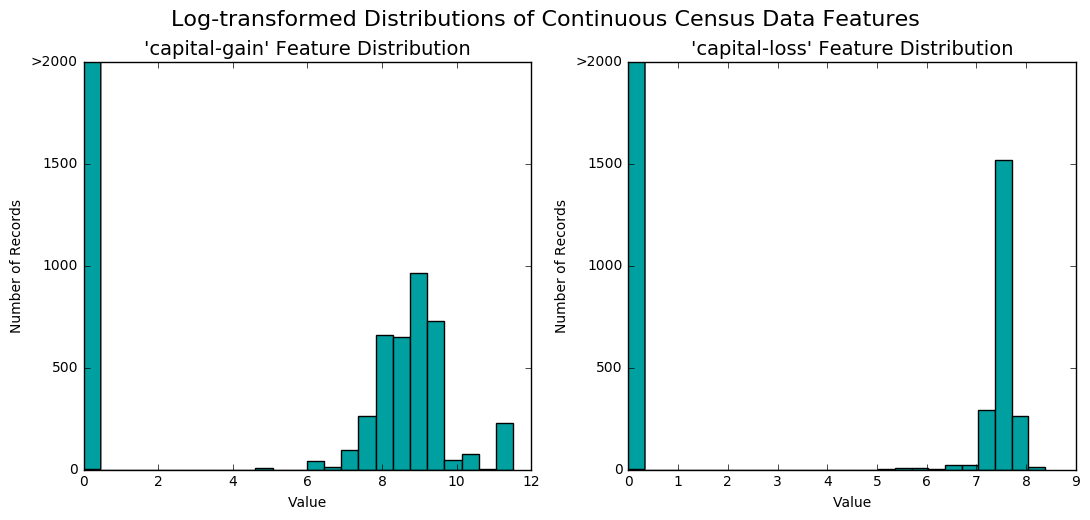

In [5]:
# Log-transform the skewed features
skewed = ['capital-gain', 'capital-loss']
features_raw[skewed] = data[skewed].apply(lambda x: np.log(x + 1))

# Visualize the new log distributions
vs.distribution(features_raw, transformed = True)

### Normalizing Numerical Features
In addition to performing transformations on features that are highly skewed, it is often good practice to perform some type of scaling on numerical features. Applying a scaling to the data does not change the shape of each feature's distribution (such as `'capital-gain'` or `'capital-loss'` above); however, normalization ensures that each feature is treated equally when applying supervised learners. Note that once scaling is applied, observing the data in its raw form will no longer have the same original meaning, as exampled below.

Run the code cell below to normalize each numerical feature. We will use [`sklearn.preprocessing.MinMaxScaler`](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html) for this.

In [6]:
# Import sklearn.preprocessing.StandardScaler
from sklearn.preprocessing import MinMaxScaler

# Initialize a scaler, then apply it to the features
scaler = MinMaxScaler()
numerical = ['age', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week']
features_raw[numerical] = scaler.fit_transform(data[numerical])

# Show an example of a record with scaling applied
display(features_raw.head(n = 1))

,age,workclass,education_level,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country
0,0.30137,State-gov,Bachelors,0.8,Never-married,Adm-clerical,Not-in-family,White,Male,0.02174,0.0,0.397959,United-States


### Implementation: Data Preprocessing

From the table in **Exploring the Data** above, we can see there are several features for each record that are non-numeric. Typically, learning algorithms expect input to be numeric, which requires that non-numeric features (called *categorical variables*) be converted. One popular way to convert categorical variables is by using the **one-hot encoding** scheme. One-hot encoding creates a _"dummy"_ variable for each possible category of each non-numeric feature. For example, assume `someFeature` has three possible entries: `A`, `B`, or `C`. We then encode this feature into `someFeature_A`, `someFeature_B` and `someFeature_C`.

|   | someFeature |                    | someFeature_A | someFeature_B | someFeature_C |
| :-: | :-: |                            | :-: | :-: | :-: |
| 0 |  B  |  | 0 | 1 | 0 |
| 1 |  C  | ----> one-hot encode ----> | 0 | 0 | 1 |
| 2 |  A  |  | 1 | 0 | 0 |

Additionally, as with the non-numeric features, we need to convert the non-numeric target label, `'income'` to numerical values for the learning algorithm to work. Since there are only two possible categories for this label ("<=50K" and ">50K"), we can avoid using one-hot encoding and simply encode these two categories as `0` and `1`, respectively. In code cell below, you will need to implement the following:
 - Use [`pandas.get_dummies()`](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.get_dummies.html?highlight=get_dummies#pandas.get_dummies) to perform one-hot encoding on the `'features_raw'` data.
 - Convert the target label `'income_raw'` to numerical entries.
   - Set records with "<=50K" to `0` and records with ">50K" to `1`.

In [7]:
# TODO: One-hot encode the 'features_raw' data using pandas.get_dummies()
features = pd.get_dummies(features_raw)

# TODO: Encode the 'income_raw' data to numerical values
income = (income_raw == '>50K').astype(int)


# Print the number of features after one-hot encoding
encoded = list(features.columns)
print "{} total features after one-hot encoding.".format(len(encoded))

# Uncomment the following line to see the encoded feature names
#print encoded

103 total features after one-hot encoding.


### Shuffle and Split Data
Now all _categorical variables_ have been converted into numerical features, and all numerical features have been normalized. As always, we will now split the data (both features and their labels) into training and test sets. 80% of the data will be used for training and 20% for testing.

Run the code cell below to perform this split.

In [8]:
# Import train_test_split
from sklearn.cross_validation import train_test_split

# Split the 'features' and 'income' data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, income, test_size = 0.2, random_state = 0)

# Show the results of the split
print "Training set has {} samples.".format(X_train.shape[0])
print "Testing set has {} samples.".format(X_test.shape[0])

Training set has 36177 samples.
Testing set has 9045 samples.


/home/ubuntu/anaconda2/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


----
## Evaluating Model Performance
In this section, we will investigate four different algorithms, and determine which is best at modeling the data. Three of these algorithms will be supervised learners of your choice, and the fourth algorithm is known as a *naive predictor*.

### Metrics and the Naive Predictor
*CharityML*, equipped with their research, knows individuals that make more than \$50,000 are most likely to donate to their charity. Because of this, *CharityML* is particularly interested in predicting who makes more than \$50,000 accurately. It would seem that using **accuracy** as a metric for evaluating a particular model's performace would be appropriate. Additionally, identifying someone that *does not* make more than \$50,000 as someone who does would be detrimental to *CharityML*, since they are looking to find individuals willing to donate. Therefore, a model's ability to precisely predict those that make more than \$50,000 is *more important* than the model's ability to **recall** those individuals. We can use **F-beta score** as a metric that considers both precision and recall:

$$ F_{\beta} = (1 + \beta^2) \cdot \frac{precision \cdot recall}{\left( \beta^2 \cdot precision \right) + recall} $$

In particular, when $\beta = 0.5$, more emphasis is placed on precision. This is called the **F$_{0.5}$ score** (or F-score for simplicity).

Looking at the distribution of classes (those who make at most \$50,000, and those who make more), it's clear most individuals do not make more than \$50,000. This can greatly affect **accuracy**, since we could simply say *"this person does not make more than \$50,000"* and generally be right, without ever looking at the data! Making such a statement would be called **naive**, since we have not considered any information to substantiate the claim. It is always important to consider the *naive prediction* for your data, to help establish a benchmark for whether a model is performing well. That been said, using that prediction would be pointless: If we predicted all people made less than \$50,000, *CharityML* would identify no one as donors. 

### Question 1 - Naive Predictor Performace
*If we chose a model that always predicted an individual made more than \$50,000, what would that model's accuracy and F-score be on this dataset?*  
**Note:** You must use the code cell below and assign your results to `'accuracy'` and `'fscore'` to be used later.

0.247843969749


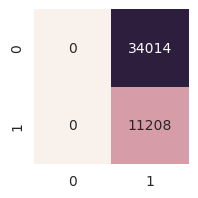

In [27]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
import seaborn as sns
plt.rcParams['figure.figsize']=(2,2)

# Predict that everybody makes more than $50k
naive_preds = np.ones(n_records)
print accuracy_score(income, naive_preds)

# False positive: model predicts 34014 individuals make more than $50k
# Correctly classified: 2205 individuals make more than $50k
# Model prediction is on the horizontal axis, ground truth is vertical
# conf_matrix = confusion_matrix(y_test, naive_preds)
conf_matrix = confusion_matrix(income, naive_preds)
sns.heatmap(conf_matrix, annot=True, fmt='d', annot_kws={"size": 10}, cbar=False);
# display(conf_matrix)

In [28]:
def get_fscore(beta):
    """Return the fscore based on the values in the confusion matrix and a given value for beta."""
    # Get (True Negative, False Positive), (False Negative, True Positive)
    (TN, FP), (FN, TP) = confusion_matrix(income, naive_preds)
    # True positive rate
    recall = float(TP) / (TP + FN)
    # Positive predictive value
    precision = float(TP) / (TP + FP)
    return (1 + beta**2) * (precision * recall) / ((beta**2 * precision) + recall)
    

In [29]:
# TODO: Calculate accuracy
accuracy = accuracy_score(income, naive_preds)

# TODO: Calculate F-score using the formula above for beta = 0.5
fscore = get_fscore(0.5)

# Print the results 
print "Naive Predictor: [Accuracy score: {:.4f}, F-score: {:.4f}]".format(accuracy, fscore)

Naive Predictor: [Accuracy score: 0.2478, F-score: 0.2917]


###  Supervised Learning Models
**The following supervised learning models are currently available in** [`scikit-learn`](http://scikit-learn.org/stable/supervised_learning.html) **that you may choose from:**
- Gaussian Naive Bayes (GaussianNB)
- Decision Trees
- Ensemble Methods (Bagging, AdaBoost, Random Forest, Gradient Boosting)
- K-Nearest Neighbors (KNeighbors)
- Stochastic Gradient Descent Classifier (SGDC)
- Support Vector Machines (SVM)
- Logistic Regression

### Question 2 - Model Application
List three of the supervised learning models above that are appropriate for this problem that you will test on the census data. For each model chosen
- *Describe one real-world application in industry where the model can be applied.* (You may need to do research for this — give references!)
- *What are the strengths of the model; when does it perform well?*
- *What are the weaknesses of the model; when does it perform poorly?*
- *What makes this model a good candidate for the problem, given what you know about the data?*

**Answer: **

1. *Ensemble methods (AdaBoost)*
    - Boosting is used extensively by machine learning practitioners in competitive programming competitions<sup>[1](#References)</sup>. One of the first notable uses of AdaBoost in particular, was in a system to detect pedestrians by analysing patterns of motion and appearance<sup>[2](#References)</sup>.
    - AdaBoost has some notable strengths. It is extremely easy to implement, and is efficient both in terms of practical performance and computational cost<sup>[4](#References)</sup>. It requires no parameter tuning, except for the number of rounds of training to generate the weak hypotheses. It does not require a prior knowledge of the weak learner, making it quite flexible, as this allows you to use any method to find weak hyoptheses<sup>[5](#References)</sup>.  
    - AdaBoost can fail to perform well if there is insufficiant data or with weak hypotheses that are overly complex, such as a neural network. Boosting is also quite susceptible to noise<sup>[5](#References)</sup>. Finally, boosting does not lend itself well to parallelism.
    - AdaBoost is considered to be an excellent out of the box classifier. It was first developed for binary classification problems, but was later extended to multi-class and regression problems. This makes it a candidate for our problem, which tries to predict one of two classes. Furthermore, it can identify outliers in the data by assigning them the largest weights, but the data doesn't have too many outliers - to the point that it is detrminetal to the performance of the algorithm<sup>[3](#References)</sup>.
<br><br>
2. *Logistic Regression*  
    - One of the applications of logistic regression in industry is to evaluate the diagnosis of medical test results<sup>[6](#References)</sup>.
    - Logistic regression has a fast run-time, and it is a very simple model to interpret. It has low variance because the model creates a linear decision boundary or hyperplane to separate the points, and is thus less prone to overfitting.
    - The linear weights in the model introduce a degree of bias in the model. This can sometimes make it unable to capture the complexity of a pattern. 
    - This model is a good candidate for this problem because we can tune it easily via grid-search and cross-validation thanks to the fast performance. We also need not worry very much about the curse of dimensionality, as the there is a good amount of data, and even if we hand-craft several additional features to train on, the model is not very liable to overfit.
<br><br>
3. *Support Vector Machines (SVM)*
    - Support vector machines have been also been used in medicine to detect diabetes and pre-diabetes in a study that was conducted on a sample of US residents<sup>[7](#References).
    - Support vector machines are effective even in cases where the number of dimensions is greater than the number of samples, unlike in linear regression, for example. It is also memory efficient during training, and very versatile due to the use of customizable kernel functions.
    - SVMs do not directly provide probability estimates, which make interpreting the results difficult. These probabilities can be calculated but are computationally expensive.
    - SVMs are a good candidate for this problem because if we later decide to split the income brackets into multiple classes, it would be easy to extend the model to this scenario<sup>[8](#References)</sup>.

<a id='References'></a>
#### References
1. Gorman, Ben (23 January 2017). "A Kaggle Master Explains Gradient Boosting". http://blog.kaggle.com/2017/01/23/a-kaggle-master-explains-gradient-boosting/
2. P. Viola, et al., "Detecting Pedestrians Using Patterns of Motion and Appearance", ICCV 2003
3. Kégl, Balázs (20 December 2013). "The return of AdaBoost.MH: multi-class Hamming trees". [arXiv:1312.6086](https://arxiv.org/abs/1312.6086)
4. Zhu, Ji et al (12 January 2006). "Multi-class AdaBoost". https://web.stanford.edu/~hastie/Papers/samme.pdf
5. Freund, Y., Schapire, Robert (September 1999). "A Short Introduction to Boosting". http://www.yorku.ca/gisweb/eats4400/boost.pdf

6. AC Janssens, et al., "A new logistic regression approach for the evaluation of diagnostic test results". https://www.ncbi.nlm.nih.gov/pubmed/15800301
7. Yu, Wei (18 December 2009). "Application of support vector machine modeling for prediction of common diseases: the case of diabetes and pre-diabetes". https://bmcmedinformdecismak.biomedcentral.com/articles/10.1186/1472-6947-10-16
8. sci-kitlearn documentation http://scikit-learn.org/stable/modules/svm.html

### Implementation - Creating a Training and Predicting Pipeline
To properly evaluate the performance of each model you've chosen, it's important that you create a training and predicting pipeline that allows you to quickly and effectively train models using various sizes of training data and perform predictions on the testing data. Your implementation here will be used in the following section.
In the code block below, you will need to implement the following:
 - Import `fbeta_score` and `accuracy_score` from [`sklearn.metrics`](http://scikit-learn.org/stable/modules/classes.html#sklearn-metrics-metrics).
 - Fit the learner to the sampled training data and record the training time.
 - Perform predictions on the test data `X_test`, and also on the first 300 training points `X_train[:300]`.
   - Record the total prediction time.
 - Calculate the accuracy score for both the training subset and testing set.
 - Calculate the F-score for both the training subset and testing set.
   - Make sure that you set the `beta` parameter!

In [30]:
# TODO: Import two metrics from sklearn - fbeta_score and accuracy_score
from sklearn.metrics import fbeta_score, accuracy_score


def train_predict(learner, sample_size, X_train, y_train, X_test, y_test): 
    '''
    inputs:
       - learner: the learning algorithm to be trained and predicted on
       - sample_size: the size of samples (number) to be drawn from training set
       - X_train: features training set
       - y_train: income training set
       - X_test: features testing set
       - y_test: income testing set
    '''
    
    results = {}
    
    # TODO: Fit the learner to the training data using slicing with 'sample_size'
    start = time() # Get start time
    learner = learner.fit(X_train[:sample_size], y_train[:sample_size])
    end = time() # Get end time
    
    # TODO: Calculate the training time
    results['train_time'] = end - start
        
    # TODO: Get the predictions on the test set,
    #       then get predictions on the first 300 training samples
    start = time() # Get start time
    predictions_test = learner.predict(X_test)
    predictions_train = learner.predict(X_train[:300])
    end = time() # Get end time
    
    # TODO: Calculate the total prediction time
    results['pred_time'] = end - start
            
    # TODO: Compute accuracy on the first 300 training samples
    results['acc_train'] = accuracy_score(predictions_train, y_train[:300])
        
    # TODO: Compute accuracy on test set
    results['acc_test'] = accuracy_score(predictions_test, y_test)
    
    # TODO: Compute F-score on the the first 300 training samples
    results['f_train'] = fbeta_score(y_train[:300], predictions_train, beta=0.5)
        
    # TODO: Compute F-score on the test set
    results['f_test'] = fbeta_score(y_test, predictions_test, beta=0.5)
       
    # Success
    print "{} trained on {} samples.".format(learner.__class__.__name__, sample_size)
        
    # Return the results
    return results

### Implementation: Initial Model Evaluation
In the code cell, you will need to implement the following:
- Import the three supervised learning models you've discussed in the previous section.
- Initialize the three models and store them in `'clf_A'`, `'clf_B'`, and `'clf_C'`.
  - Use a `'random_state'` for each model you use, if provided.
  - **Note:** Use the default settings for each model — you will tune one specific model in a later section.
- Calculate the number of records equal to 1%, 10%, and 100% of the training data.
  - Store those values in `'samples_1'`, `'samples_10'`, and `'samples_100'` respectively.

**Note:** Depending on which algorithms you chose, the following implementation may take some time to run!

AdaBoostClassifier trained on 362 samples.
AdaBoostClassifier trained on 3618 samples.
AdaBoostClassifier trained on 36177 samples.
LogisticRegression trained on 362 samples.
LogisticRegression trained on 3618 samples.
LogisticRegression trained on 36177 samples.
SVC trained on 362 samples.
SVC trained on 3618 samples.
SVC trained on 36177 samples.


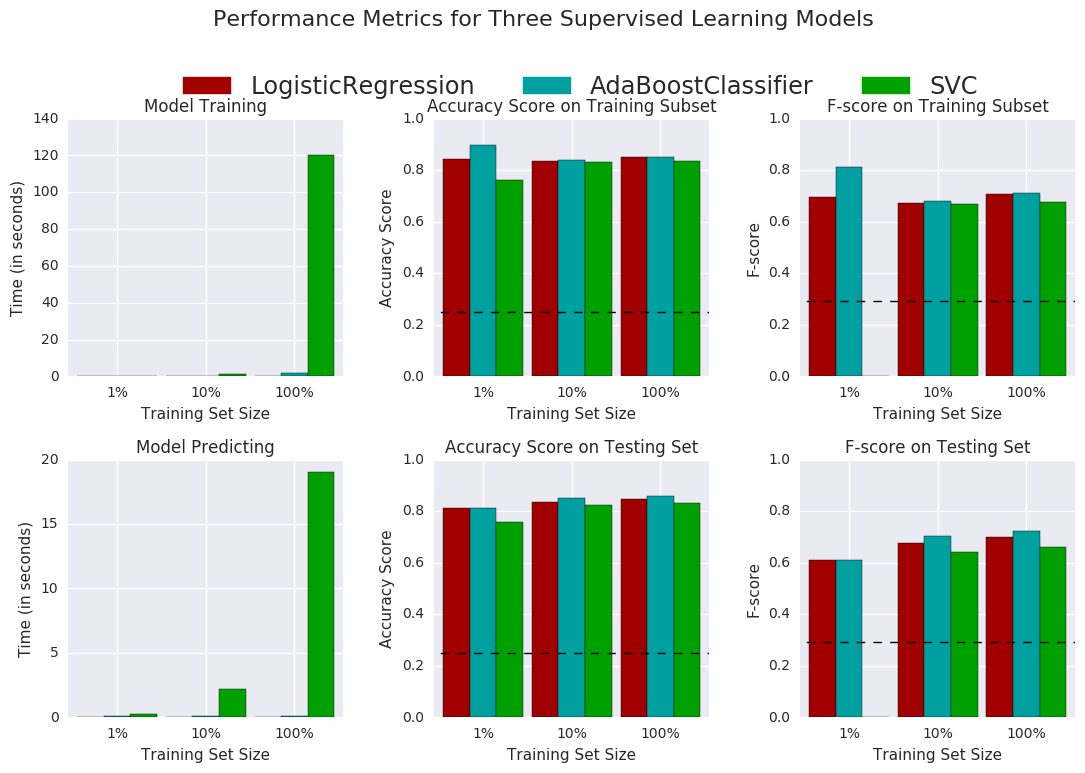

In [32]:
# TODO: Import the three supervised learning models from sklearn
from sklearn.ensemble import AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

# TODO: Initialize the three models
clf_A = AdaBoostClassifier(random_state=0)
clf_B = LogisticRegression(random_state=0)
clf_C = SVC(random_state=0)

# TODO: Calculate the number of samples for 1%, 10%, and 100% of the training data
samples_1 = int(round(0.01 * len(X_train)))
samples_10 = int(round(0.10 * len(X_train)))
samples_100 = len(X_train)

# Collect results on the learners
results = {}
for clf in [clf_A, clf_B, clf_C]:
    clf_name = clf.__class__.__name__
    results[clf_name] = {}
    for i, samples in enumerate([samples_1, samples_10, samples_100]):
        results[clf_name][i] = \
        train_predict(clf, samples, X_train, y_train, X_test, y_test)

# Run metrics visualization for the three supervised learning models chosen
vs.evaluate(results, accuracy, fscore)

In [14]:
from pprint import pprint
# pprint(results)

----
## Improving Results
In this final section, you will choose from the three supervised learning models the *best* model to use on the student data. You will then perform a grid search optimization for the model over the entire training set (`X_train` and `y_train`) by tuning at least one parameter to improve upon the untuned model's F-score. 

### Question 3 - Choosing the Best Model
*Based on the evaluation you performed earlier, in one to two paragraphs, explain to *CharityML* which of the three models you believe to be most appropriate for the task of identifying individuals that make more than \$50,000.*  
**Hint:** Your answer should include discussion of the metrics, prediction/training time, and the algorithm's suitability for the data.

**Answer: **The most appropriate model for the task of identifying indiviuals that make more than $50,000 is the AdaBoost classifier. It has excellent performance for both training and predicting, even when using the entire training set. The logistic regression model does have slightly faster performance, but AdaBoost has slightly better accuracy out of the box. One thing to be aware of is that the AdaBoost algorithm apears to be overfitting when the training set is very small, as it has an accuracy of close to 90% on the training set but in the low 80s on the test set. If for some reason we had a very small number of observations, I would consider picking logistic regression. However, in this case we have a sufficient number of examples, and it may be possible to easily tune AdaBoost further for even better accuracy.

### Question 4 - Describing the Model in Layman's Terms
*In one to two paragraphs, explain to *CharityML*, in layman's terms, how the final model chosen is supposed to work. Be sure that you are describing the major qualities of the model, such as how the model is trained and how the model makes a prediction. Avoid using advanced mathematical or technical jargon, such as describing equations or discussing the algorithm implementation.*

**Answer: ** AdaBoost is an algorithm that tries to classify on object into one of two possible categories. It does this by combining many weak learners together to form a single decision. A weak learner is any classifier that performs slightly better than chance.

Suppose there are three weak learners. Each one may individually be more accurate in different parts of the problem. This can be seen in the upper part of the representation shown below. The picture shows how a different learner is wrong in different parts of the problem domain, so combining them together prove to be a fruitful result. In the lower part the situation is a but more murky, because now there is some overlap in the areas each learner gets wrong. It may the, occur to us that we can try to determine which learner is *more* correct than the others. We shall step through an example to see how the training process works.

<img src='mlnd_proj2.png'/>

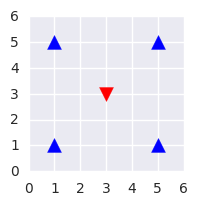

In [15]:
import plots; reload(plots)
fig1 = plots.initial_plot()

We have five points we would like to separate by color. Each point is initially given equal importance. A simple learner that is often used with AdaGrad is known as a decision tree stump. This simply draws a horizontal or vertical line in a way that separates the points.

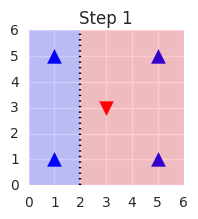

In [16]:
plots.step_1(fig1)

The first hypothesis divides the points in a way such that everything on the left is classified as blue, and everything on the right is classified as red.
We see that the two blue points on the left are classified correctly, but the ones on the right are classified incorrectly.

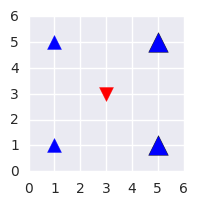

In [17]:
fig2 = plots.emphasize_incorrect()

The points shown in the right were classified incorrectly, so we increase their importance for the next step. This is indicated in the graph above by the increased size of the points. The algorithm will then place a high priority on getting these two points correct in the next step.

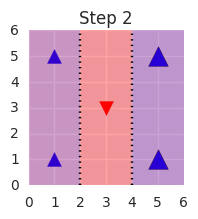

In [18]:
plots.step_2(fig2)

A second decision boundary is created which correctly classifies all the points on the right of the line as blue. It does, however, classify the original blue points incorrectly.

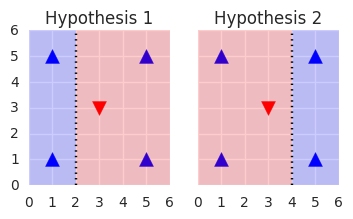

In [19]:
fig3 = plots.show_hypotheses()

We can see the two hypotheses separately above. Each outcome is given a certain weight, so that when they are combined, we obtain the final result shown below.

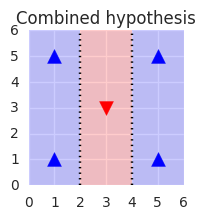

In [20]:
fig4 = plots.combined_hypothesis()

At this point the training has concluded. Now, when the model is fed new data, it will identify it based on the region that it belongs to. So, for example, if a new point from the test set is the point $(3, 1)$, the model will classify it as red because it belongs to the red region.

### Implementation: Model Tuning
Fine tune the chosen model. Use grid search (`GridSearchCV`) with at least one important parameter tuned with at least 3 different values. You will need to use the entire training set for this. In the code cell below, you will need to implement the following:
- Import [`sklearn.grid_search.GridSearchCV`](http://scikit-learn.org/0.17/modules/generated/sklearn.grid_search.GridSearchCV.html) and [`sklearn.metrics.make_scorer`](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.make_scorer.html).
- Initialize the classifier you've chosen and store it in `clf`.
 - Set a `random_state` if one is available to the same state you set before.
- Create a dictionary of parameters you wish to tune for the chosen model.
 - Example: `parameters = {'parameter' : [list of values]}`.
 - **Note:** Avoid tuning the `max_features` parameter of your learner if that parameter is available!
- Use `make_scorer` to create an `fbeta_score` scoring object (with $\beta = 0.5$).
- Perform grid search on the classifier `clf` using the `'scorer'`, and store it in `grid_obj`.
- Fit the grid search object to the training data (`X_train`, `y_train`), and store it in `grid_fit`.

**Note:** Depending on the algorithm chosen and the parameter list, the following implementation may take some time to run!

In [21]:
# view parameters for AdaBoost
clf_A.get_params().keys()

['n_estimators',
 'base_estimator',
 'random_state',
 'learning_rate',
 'algorithm']

In [35]:
# TODO: Import 'GridSearchCV', 'make_scorer', and any other necessary libraries
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import make_scorer

# TODO: Initialize the classifier
clf = AdaBoostClassifier(random_state=0)

# TODO: Create the parameters list you wish to tune
parameters = {'n_estimators': [100, 200, 400], 'learning_rate': [1.0, 0.1, 0.01]}

# TODO: Make an fbeta_score scoring object
scorer = make_scorer(fbeta_score, beta=0.5)

# TODO: Perform grid search on the classifier using 'scorer' as the scoring method
grid_obj = GridSearchCV(clf, parameters, scoring=scorer)

# TODO: Fit the grid search object to the training data and find the optimal parameters
grid_fit = grid_obj.fit(X_train, y_train)

# Get the estimator
best_clf = grid_fit.best_estimator_

# Make predictions using the unoptimized and model
predictions = (clf.fit(X_train, y_train)).predict(X_test)
best_predictions = best_clf.predict(X_test)

# Report the before-and-afterscores
print "Unoptimized model\n------"
print "Accuracy score on testing data: {:.4f}".format(accuracy_score(y_test, predictions))
print "F-score on testing data: {:.4f}".format(fbeta_score(y_test, predictions, beta = 0.5))
print "\nOptimized Model\n------"
print "Final accuracy score on the testing data: {:.4f}".format(accuracy_score(y_test, best_predictions))
print "Final F-score on the testing data: {:.4f}".format(fbeta_score(y_test, best_predictions, beta = 0.5))

Unoptimized model
------
Accuracy score on testing data: 0.8576
F-score on testing data: 0.7246

Optimized Model
------
Final accuracy score on the testing data: 0.8652
Final F-score on the testing data: 0.7401


### Question 5 - Final Model Evaluation
_What is your optimized model's accuracy and F-score on the testing data? Are these scores better or worse than the unoptimized model? How do the results from your optimized model compare to the naive predictor benchmarks you found earlier in **Question 1**?_  
**Note:** Fill in the table below with your results, and then provide discussion in the **Answer** box.

#### Results:

|     Metric     | Benchmark Predictor | Unoptimized Model | Optimized Model |
| :------------: | :-----------------: | :---------------: | :-------------: | 
| Accuracy Score | 0.2478              |   0.8576          |   0.8652        |
| F-score        | 0.2917              |   0.7246          |  0.7401         |


**Answer: **The scores for the unoptimized model are significantly better than the naive benchmark predictor. An accuracy of 85.76% is quite remarkable for an algorithm that was used with almost no effort. Optimizing the model involved trying out different learning rates and number of estimators. This yielded a small improvement, bumping up the accuracy to 86.54%. Using this model, it is probably possible to increase the accuracy further by experimenting with different kinds of weak learners or increasing the number of estimors even more.

----
## Feature Importance

An important task when performing supervised learning on a dataset like the census data we study here is determining which features provide the most predictive power. By focusing on the relationship between only a few crucial features and the target label we simplify our understanding of the phenomenon, which is most always a useful thing to do. In the case of this project, that means we wish to identify a small number of features that most strongly predict whether an individual makes at most or more than \$50,000.

Choose a scikit-learn classifier (e.g., adaboost, random forests) that has a `feature_importance_` attribute, which is a function that ranks the importance of features according to the chosen classifier.  In the next python cell fit this classifier to training set and use this attribute to determine the top 5 most important features for the census dataset.

### Question 6 - Feature Relevance Observation
When **Exploring the Data**, it was shown there are thirteen available features for each individual on record in the census data.  
_Of these thirteen records, which five features do you believe to be most important for prediction, and in what order would you rank them and why?_

**Answer: **Most important features:

1. **Country**  
    There is a significant difference in per capita GDP between wealthy countries and developing ones. I expect that this would be correlated highly with the income a person might make.
2. **Occupation**  
    People in some professions such as law and medicine make a lot more money than others, such as teachers or cab drivers.
3. **Education**    
    A person with a PhD would, on average, earn a lot more than a person with just a high school diploma. One thing I would be concerned about is the possible overlap in education and occupation features. For example, most high paying occupations require advanced degrees.
4. **Hours per week**    
    Everything else being equal, a person working longer hours is going to earn more money in a year.
5. **Age**  
    Older individuals tend to be more experienced, and therefore would earn more money. However, this would no longer hold after retirement.

### Implementation - Extracting Feature Importance
Choose a `scikit-learn` supervised learning algorithm that has a `feature_importance_` attribute availble for it. This attribute is a function that ranks the importance of each feature when making predictions based on the chosen algorithm.

In the code cell below, you will need to implement the following:
 - Import a supervised learning model from sklearn if it is different from the three used earlier.
 - Train the supervised model on the entire training set.
 - Extract the feature importances using `'.feature_importances_'`.

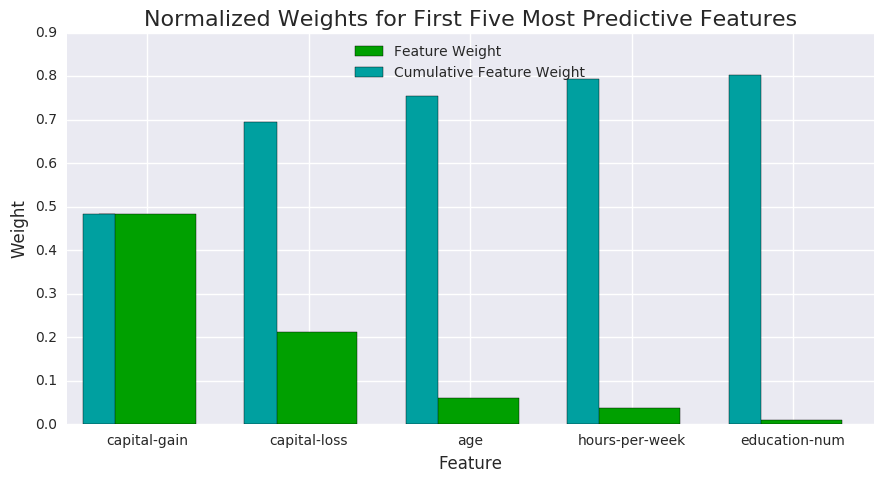

In [36]:
# TODO: Import a supervised learning model that has 'feature_importances_'
# Already imported above
# from sklearn.ensemble import AdaBoostClassifier

# TODO: Train the supervised model on the training set 
# model = AdaBoostClassifier()
best_clf.fit(X_train, y_train)

# TODO: Extract the feature importances
importances = best_clf.feature_importances_

# Plot
vs.feature_plot(importances, X_train, y_train)

### Question 7 - Extracting Feature Importance

Observe the visualization created above which displays the five most relevant features for predicting if an individual makes at most or above \$50,000.  
_How do these five features compare to the five features you discussed in **Question 6**? If you were close to the same answer, how does this visualization confirm your thoughts? If you were not close, why do you think these features are more relevant?_

**Answer:** The features I correctly anticipated were the most important were age, hours per week and education, though not in that order. This is not surprising, because there is certainly a large difference between the salaries of a doctor and a cashier, for example. Similarly, age is a proxy for experience, and spending more hours working would yield more pay. I did not correctly identify the capital-gain and capital-loss features, although upon reflection capital-gain might be considered an obvious candidate because individuals with a higher income are more likely to have more disposable income to invest with. I'm not sure it's very intuitive as to why capital-loss is such an important feature, but it makes sense that people with a higher income, and thus greater wealth, also have more to lose. It would appear that collectively these five features explain more than 50% of the variance in the data.

### Feature Selection
How does a model perform if we only use a subset of all the available features in the data? With less features required to train, the expectation is that training and prediction time is much lower — at the cost of performance metrics. From the visualization above, we see that the top five most important features contribute more than half of the importance of **all** features present in the data. This hints that we can attempt to *reduce the feature space* and simplify the information required for the model to learn. The code cell below will use the same optimized model you found earlier, and train it on the same training set *with only the top five important features*. 

In [24]:
# Import functionality for cloning a model
from sklearn.base import clone

# Reduce the feature space
X_train_reduced = X_train[X_train.columns.values[(np.argsort(importances)[::-1])[:5]]]
X_test_reduced = X_test[X_test.columns.values[(np.argsort(importances)[::-1])[:5]]]

# Train on the "best" model found from grid search earlier
clf = (clone(best_clf)).fit(X_train_reduced, y_train)

# Make new predictions
reduced_predictions = clf.predict(X_test_reduced)

# Report scores from the final model using both versions of data
print "Final Model trained on full data\n------"
print "Accuracy on testing data: {:.4f}".format(accuracy_score(y_test, best_predictions))
print "F-score on testing data: {:.4f}".format(fbeta_score(y_test, best_predictions, beta = 0.5))
print "\nFinal Model trained on reduced data\n------"
print "Accuracy on testing data: {:.4f}".format(accuracy_score(y_test, reduced_predictions))
print "F-score on testing data: {:.4f}".format(fbeta_score(y_test, reduced_predictions, beta = 0.5))

Final Model trained on full data
------
Accuracy on testing data: 0.8652
F-score on testing data: 0.7401

Final Model trained on reduced data
------
Accuracy on testing data: 0.8417
F-score on testing data: 0.7017


### Question 8 - Effects of Feature Selection
*How does the final model's F-score and accuracy score on the reduced data using only five features compare to those same scores when all features are used?*  
*If training time was a factor, would you consider using the reduced data as your training set?*

**Answer:**  The accuracy score and f-score are both less using the reduced set of features for training. It is worth considering the reduced data if training time were a real concern. That is, if using the full data set really weren't feasible, then the model trained on the reduced data certainly has comparable accuracy. However, a difference of 2.5% translates into over a thousand individuals that were misclassified. In particular, if we look at the confusion matrices below, we see that we forego almost 400 potential donors. If training on the full data set were a matter of added cost, it may well be worth it.

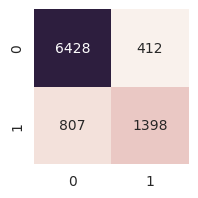

In [25]:
conf_matrix = confusion_matrix(y_test, best_predictions)
sns.heatmap(conf_matrix, annot=True, fmt='d', annot_kws={"size": 10}, cbar=False);

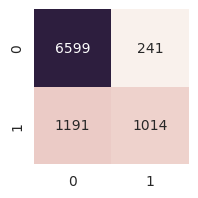

In [26]:
conf_matrix = confusion_matrix(y_test, reduced_predictions)
sns.heatmap(conf_matrix, annot=True, fmt='d', annot_kws={"size": 10}, cbar=False);

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  
**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.